In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, LinearLocator)

import matplotlib.ticker as mtick
from collections import OrderedDict
import pandas as pd
import numpy as np
# import dill
import argparse
import pyrep.backend.sim as sim
from networks.structures import PolicyNetwork, ValueNetwork, SoftQNetwork
import torch
import os
from sim_framework.envs.drone_env import DroneEnv
from mpl_toolkits.mplot3d import Axes3D


%matplotlib inline

# Utils

In [2]:
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

In [3]:
def plot_graphs(df1,df2,df1_target, df2_target, trajectory, namefig, **kwargs):
    
    if trajectory == 'Line':
        x_lim, y_lim, z_lim = (-0.5,5.5), (-0.4,0.2) ,(1.3, 2.3)
    elif trajectory == 'Square':
        x_lim, y_lim, z_lim = (-1.1, 0.8), (-1.25,0.8) ,(1.1, 2.3)
    elif trajectory == 'Senoid':
        x_lim, y_lim, z_lim = (-0.1,2.0), (-0.4,0.2) ,(0.5, 3.5)
    else:
        raise ValueError

    linewidth=0.8
        
    
    fig,ax = plt.subplots(figsize=set_size(325, fraction = 0.5), dpi=600)
    ax.plot(df1.index, df1['Posx'] + df1_target['Posx'], label = 'V1 - 0.2 m/s',  linewidth=linewidth)
    ax.plot(df2.index, df2['Posx'] + df2_target['Posx'] , label =  'V2 - 1.5 m/s' ,  linewidth=linewidth)
    ax.plot(df1.index , df1_target['Posx'], label = 'Ground Truth - V1',  linewidth=linewidth)
    ax.plot(df2.index, df2_target['Posx'], label = 'Ground Truth - V2',   linewidth=linewidth)
    plt.ylabel('x (m)', size=9, )
    plt.xlabel('Time (s)', size=9)
    plt.legend(prop={'size': 4.5})
    plt.tick_params(which='both', labelsize=7)
    ax.yaxis.set_minor_locator(AutoMinorLocator(n=2))
    ax.xaxis.set_minor_locator(AutoMinorLocator(n=2))
    ax.set_ylim(x_lim)
    
    strFile = 'figures/{0}_{1}_Position_x.pdf'.format(namefig,trajectory)
                
    if os.path.isfile(strFile):
        os.remove(strFile)   # Opt.: os.system("rm "+strFile)
    plt.savefig(strFile, format='pdf', bbox_inches='tight')


    fig,ax = plt.subplots(figsize=set_size(325, fraction = 0.5), dpi=600)
    ax.plot(df1.index, df1['Posy'] + df1_target['Posy'], label = 'V1 - 0.2 m/s', linewidth = linewidth  )
    ax.plot(df2.index, df2['Posy'] + df2_target['Posy'] , label =  'V2 - 1.5 m/s', linewidth = linewidth  )
    ax.plot(df1.index , df1_target['Posy'], label = 'Ground Truth - V1', linewidth = linewidth  )
    ax.plot(df2.index, df2_target['Posy'], label = 'Ground Truth - V2', linewidth = linewidth  )
#     plt.title('Drone position in a {0} trajectory'.format(trajectory), size=20)
    plt.ylabel('y (m)', size=9)
    plt.xlabel('Time (s)', size=9)
#     plt.legend(prop={'size': 4.5})
    plt.tick_params(which='both', labelsize=7)
    ax.yaxis.set_minor_locator(AutoMinorLocator(n=2))
    ax.xaxis.set_minor_locator(AutoMinorLocator(n=2))
    ax.set_ylim(y_lim)
    
#     ax.set_xlim([-0.4,0.2])

    strFile = 'figures/{0}_{1}_Position_y.pdf'.format(namefig,trajectory)
    
    if os.path.isfile(strFile):
        os.remove(strFile)   # Opt.: os.system("rm "+strFile)
    plt.savefig(strFile, format='pdf', bbox_inches='tight')

    

#     fig,ax = plt.subplots(figsize=(15,8))
    fig,ax = plt.subplots(figsize=set_size(325, fraction = 0.5), dpi=600)
    
    ax.plot(df1.index, df1['Posz'] + df1_target['Posz'], label = 'V1 - 0.2 m/s',  linewidth = linewidth  )
    ax.plot(df2.index, df2['Posz'] + df2_target['Posz'] , label =  'V2 - 1.5 m/s', linewidth = linewidth  )
    ax.plot(df1.index , df1_target['Posz'], label = 'Ground Truth - V1', linewidth = linewidth  )
    ax.plot(df2.index, df2_target['Posz'], label = 'Ground Truth - V2',  linewidth = linewidth  )
#     plt.title('Drone position in a {0} trajectory'.format(trajectory), size=20)
    plt.ylabel('z (m)', size=9)
    plt.xlabel('Time (s)', size=9)
#     plt.legend(prop={'size': 4.5})
    plt.tick_params(which='both', labelsize=7)
    ax.yaxis.set_minor_locator(AutoMinorLocator(n=2))
    ax.xaxis.set_minor_locator(AutoMinorLocator(n=2))
    ax.set_ylim(z_lim)

    strFile = 'figures/{0}_{1}_Position_z.pdf'.format(namefig,trajectory)
    
    if os.path.isfile(strFile):
        os.remove(strFile)   # Opt.: os.system("rm "+strFile)
    plt.savefig(strFile, format='pdf', bbox_inches='tight')
    


    fig = plt.figure(figsize=(5.3,4.3))

    
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(df1_target['Posx'], df1_target['Posy'] , df1_target['Posz'], label =  'Ground Truth' ,linewidth = linewidth)
    ax.plot(df1_target['Posx']+ df1['Posx'], df1_target['Posy'] + df1['Posy'] ,\
                                df1_target['Posz'] + df1['Posz'], label =  'V1 - 0.2 m/s' ,linewidth = linewidth)
    ax.plot(df2_target['Posx']+ df2['Posx'], df2_target['Posy'] + df2['Posy'] ,\
                                df2_target['Posz'] + df2['Posz'], label = 'V2 - 1.5 m/s' ,linewidth = linewidth) 
    
    ax.set_zlim([0,4.0]) 

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim) 
    ax.set_xlabel('\nx (m)', size = 9,  )
    ax.set_ylabel('\ny (m)', size = 9,  )
    ax.set_zlabel('z (m)', size = 9,  )
    plt.tick_params(which='both', labelsize=8)
    plt.legend(prop={'size': 6})
    ax.tick_params(which='minor', width=2, length=4)
    ax.tick_params(which='major', length=8, width=2)
    plt.tight_layout()
    plt.subplots_adjust(left=-0.1, bottom=None, right=None, top=None, wspace=None, hspace=None)

    namefig="SAC"
    strFile = 'figures/{0}_{1}_3DPosition4.pdf'.format(namefig,trajectory)
    if os.path.isfile(strFile):
        os.remove(strFile)   # Opt.: os.system("rm "+strFile)
    #     plt.savefig(strFile, format='pdf', bbox_inches='tight')
    plt.savefig(strFile, format='pdf', pad_inches=0)


In [4]:
def prepare_graphs_sac(set_tau1, set_tau2, trajectory, namefig):
    
    df1 = pd.DataFrame(np.array(set_tau1['obs']).squeeze()[:,:3], columns = ['Posx', 'Posy', 'Posz'])
    df1_target = pd.DataFrame(np.array(set_tau1['target_obs']).squeeze(),  columns = ['Posx', 'Posy', 'Posz']) 
    df2 = pd.DataFrame(np.array(set_tau2['obs']).squeeze()[:,:3], columns = ['Posx', 'Posy', 'Posz'])
    df2_target = pd.DataFrame(np.array(set_tau2['target_obs']).squeeze(),  columns = ['Posx', 'Posy', 'Posz']) 
    
    df1.index = [x*0.05 for x in df1.index] 
    df1_target.index = df1.index
    
    df2.index = df2.index*0.05 

    df2_target.index = df2.index
    
    plot_graphs(df1,df2,df1_target , df2_target, trajectory, namefig)



In [5]:
def run_policy(args):
    """
    Loads a and evaluates a trained policy  

    Parameters
    ----------
    args : [dict]
        Users arguments with the options for the framework
    """

    use_cuda = torch.cuda.is_available()
    if use_cuda and (args.use_cuda == True):
        device=torch.device("cuda")
    else:
        device=torch.device("cpu")

        
    try:
        env.shutdown()
    except:
        pass

    # Set environment
    env = DroneEnv(random=args.env_reset_mode, headless=args.headless, seed=args.seed, 
        reward_function_name=args.reward_function,state=args.state,
        SCENE_FILE=task_dict[args.task]['SCENE_FILE'], restart=True)  

    restore_path = args.file    
    print('Loading')
    # Load parameters if necessary
    try:
        checkpoint = torch.load(restore_path, map_location='cpu')
    except:
        checkpoint = torch.load(restore_path, map_location=torch.device('cpu'))
    print('Finished Loading')

    # Neural network parameters
    try:
        state_dim = env.observation_space.shape[0]
    except:
        state_dim = env.observation_space
    action_dim = env.action_space.shape[0]
    hidden_dim = checkpoint['linear1.weight'].data.shape[0]
    action_range = [env.agent.action_space.low.min(), env.agent.action_space.high.max()]
    size_obs = checkpoint['linear1.weight'].data.shape[1]

    assert size_obs == state_dim, 'Checkpoint state must be the same as the env'

    
   # Networks instantiation
    policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)


    # Loading  Models
    policy_net.load_state_dict(checkpoint)
    print('Finished Loading the weights')

    print("Running the policy with time_horizon = ...",  args.H)
    set_tau = rollouts(env, policy_net,\
            action_range, device, max_timesteps = args.max_timesteps,  time_horizon=args.H)
    
    print('Closing env')
    env.shutdown()

    return set_tau

In [6]:
def rollouts(env, policy, action_range, device,  max_timesteps=1000,  time_horizon=250):
    """
    Perform policy rollouts until a max given number of steps

    Parameters
    ----------
    env : 
        A larocs_sim environment
    policy : 
        An actor-policy for the agent act in the environment
    action_range : list
        Range of possible float values for the action
    max_timesteps : int, optional
        Number of timesteps to perform while interacting with the environment, by default 1000
    time_horizon : int, optional
        The number of steps for each episode, by default 250

    """
      

    assert max_timesteps % time_horizon == 0, 'The argument "max_timesteps" must be a multiple of "time_horizon"'
  
    count = 0
    dones = False
    set_of_obs, set_of_next_obs, set_of_rewards, set_of_actions,set_of_dones, set_of_infos, set_of_targets_obs = [], [], [], [], [], [], []

    rollout = -1

    while True:
        mb_obs, mb_next_obs, mb_rewards, mb_actions, mb_dones, mb_infos, mb_target_obs = [], [], [], [], [], [], []
        sim.simRemoveBanner(sim.sim_handle_all)
        rollout += 1

        obs0 = env.reset()

        sim.simAddBanner(label="Rollout = {0}".format(rollout).encode('ascii'),
                         size=0.2,
                         options=1,
                         positionAndEulerAngles=[0, 0, 2.5, 1.3, 0, 0],
                         parentObjectHandle=-1)

        for j in range(time_horizon):
            dones = False
            if count == max_timesteps:
                set_tau = {'obs': set_of_obs,
                           'next_obs': set_of_next_obs,
                           'rewards': set_of_rewards,
                           'actions': set_of_actions,
                           'dones': set_of_dones,
                           'infos': set_of_infos,
                            'target_obs' : set_of_targets_obs,
                          }
                return set_tau
            try:
                actions, agent_info = policy.deterministic_action(
                    state_to_tensor(obs0, device))
            except:
                actions = policy.deterministic_action(
                    state_to_tensor(obs0, device))

            # Take actions in env and look the results
            obs1, rewards, dones, infos = env.step(actions*action_range[1])
            # Append on the experience buffers
            mb_obs.append(obs0.copy())
            # mb_obs.append(obs0)
            mb_next_obs.append(obs1)
            mb_actions.append(actions)
            mb_dones.append(dones)
            mb_rewards.append(rewards)
            mb_infos.append(infos)
            mb_target_obs.append(env.target.get_position())

            count += 1

            if dones == True:
                break

            obs0 = obs1

        print()
        print('rewards: mean = {0}'.format(np.mean(mb_rewards)))
        print('rewards: sum = {0}'.format(np.sum(mb_rewards)))

        set_of_obs.append(mb_obs)
        set_of_next_obs.append(mb_next_obs)
        set_of_rewards.append(mb_rewards)
        set_of_actions.append(mb_actions)
        set_of_dones.append(mb_dones)
        set_of_infos.append(mb_infos)
        set_of_targets_obs.append(mb_target_obs)


In [7]:
def state_to_tensor(state, device):
    """Transform numpy array to torch tensor"""
    if args.use_double:
        return torch.DoubleTensor(state).unsqueeze(0).to(device)
    else:
        return torch.FloatTensor(state).unsqueeze(0).to(device)

# Shared Data

In [8]:
class Args():
    def __init__(self):
        pass
args=Args()
args.env_reset_mode=False
args.render=False
headless=False
args.H=250
device = torch.device('cpu')
args.reward_function = 'Normal'
args.state = 'New_action'
args.seed = 42
args.file = '../saved_policies/sac_optimal_policy_2.pt'
args.file = '../saved_policies/sac_optimal_policy.pt'

args.use_double = False


In [11]:
time_horizon = 250
task_dict = {'Normal' : {'time_horizon' : 250,  'SCENE_FILE' : None},
#                  'Line' : {'time_horizon' : 525,  'SCENE_FILE' : '/../../scenes/drone_trajectories/ardrone_mh_line.ttt'},
                 'Line' : {'time_horizon' : 525,  'SCENE_FILE' : '/../../scenes/drone_trajectories/ardrone_mh_line.ttt'},
                 'Line2' : {'time_horizon' : 70,  'SCENE_FILE' : '/../../scenes/drone_trajectories/ardrone_mh_line2.ttt'},
                 'Square2' : {'time_horizon' : 225,  'SCENE_FILE' : '/../../scenes/drone_trajectories/ardrone_mh_square2.ttt'},
                 'Square' : {'time_horizon' : 565,  'SCENE_FILE' : '/../../scenes/drone_trajectories/ardrone_mh_square.ttt'},
                 'Sinusoidal' : {'time_horizon' : 900,  'SCENE_FILE' : '/../../scenes/drone_trajectories/ardrone_mh_senoid.ttt'},
                 'Sinusoidal2' : {'time_horizon' : 120,  'SCENE_FILE' : '/../../scenes/drone_trajectories/ardrone_mh_senoid2.ttt'},
                 'Circle' : {'time_horizon' : 340,  'SCENE_FILE' : '/../../scenes/drone_trajectories/ardrone_mh_circle.ttt'},
                }   


# Line

## V1

In [10]:
args.headless=False
args.headless=True

args.task = 'Line'
args.H = task_dict[args.task]['time_horizon']
args.max_timesteps=args.H
# env_reset_mode=False

try: ## hack for jupyter
    env.shutdown()
except:
    pass
set_tau_line1_sac = run_policy(args)


/home/gabriel/anaconda3/envs/pyrep_raw/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Loading
Finished Loading
Finished Loading the weights
Running the policy with time_horizon = ... 525

rewards: mean = 3.7021364627575593
rewards: sum = 1943.6216429477186
Closing env


## V2

In [12]:
args.headless=True
args.task = 'Line2'
args.H = task_dict[args.task]['time_horizon']
args.max_timesteps=args.H
# env_reset_mode=False

try: ## hack for jupyter
    env.shutdown()
except:
    pass
set_tau_line2_sac = run_policy(args)


Loading
Finished Loading
Finished Loading the weights
Running the policy with time_horizon = ... 70

rewards: mean = 2.670414912597406
rewards: sum = 186.92904388181842
Closing env


## Plot

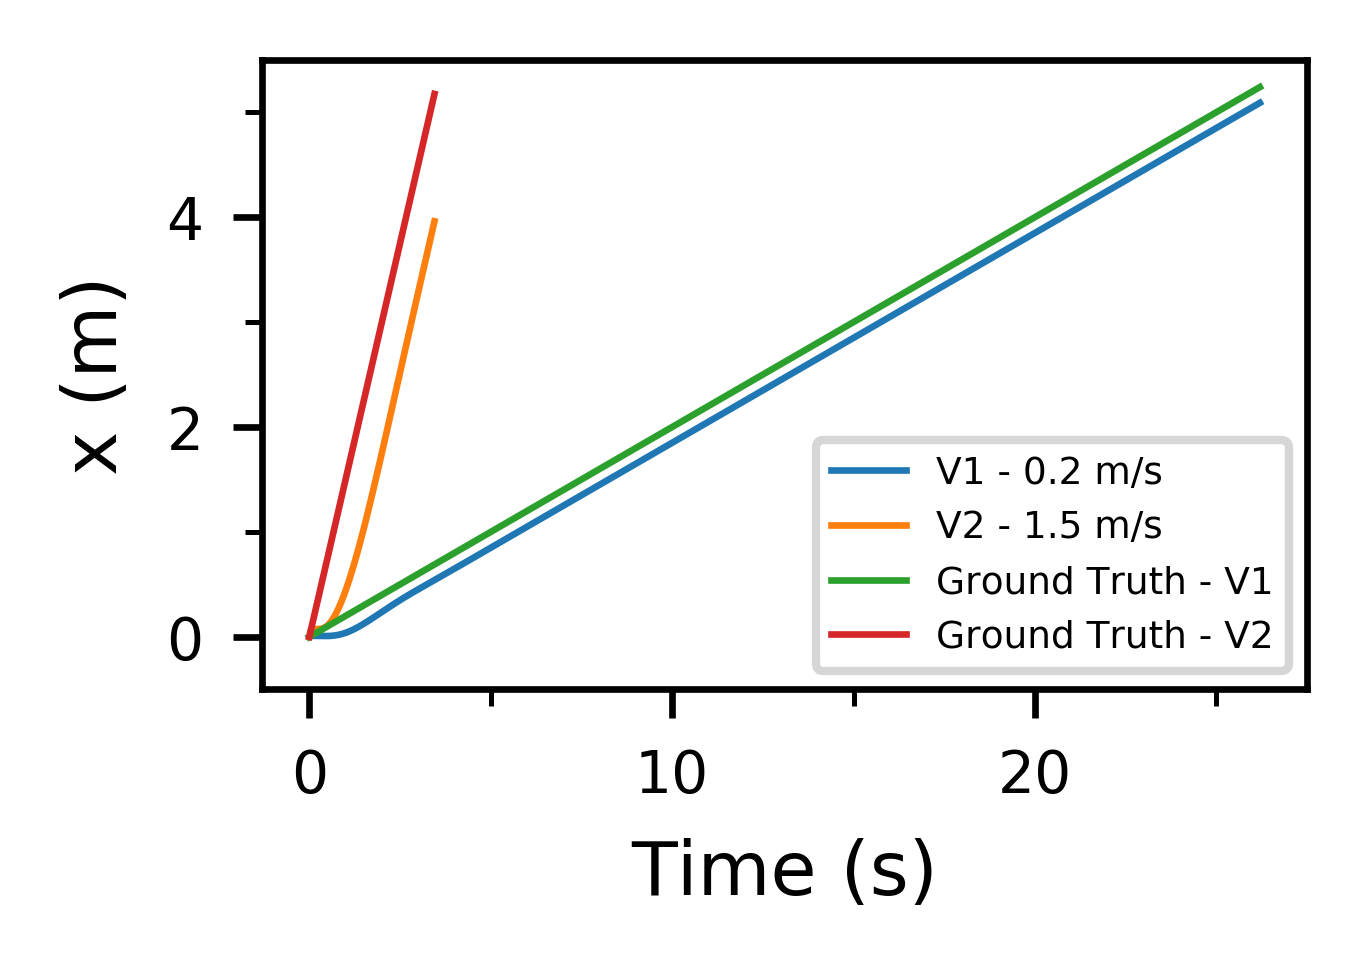

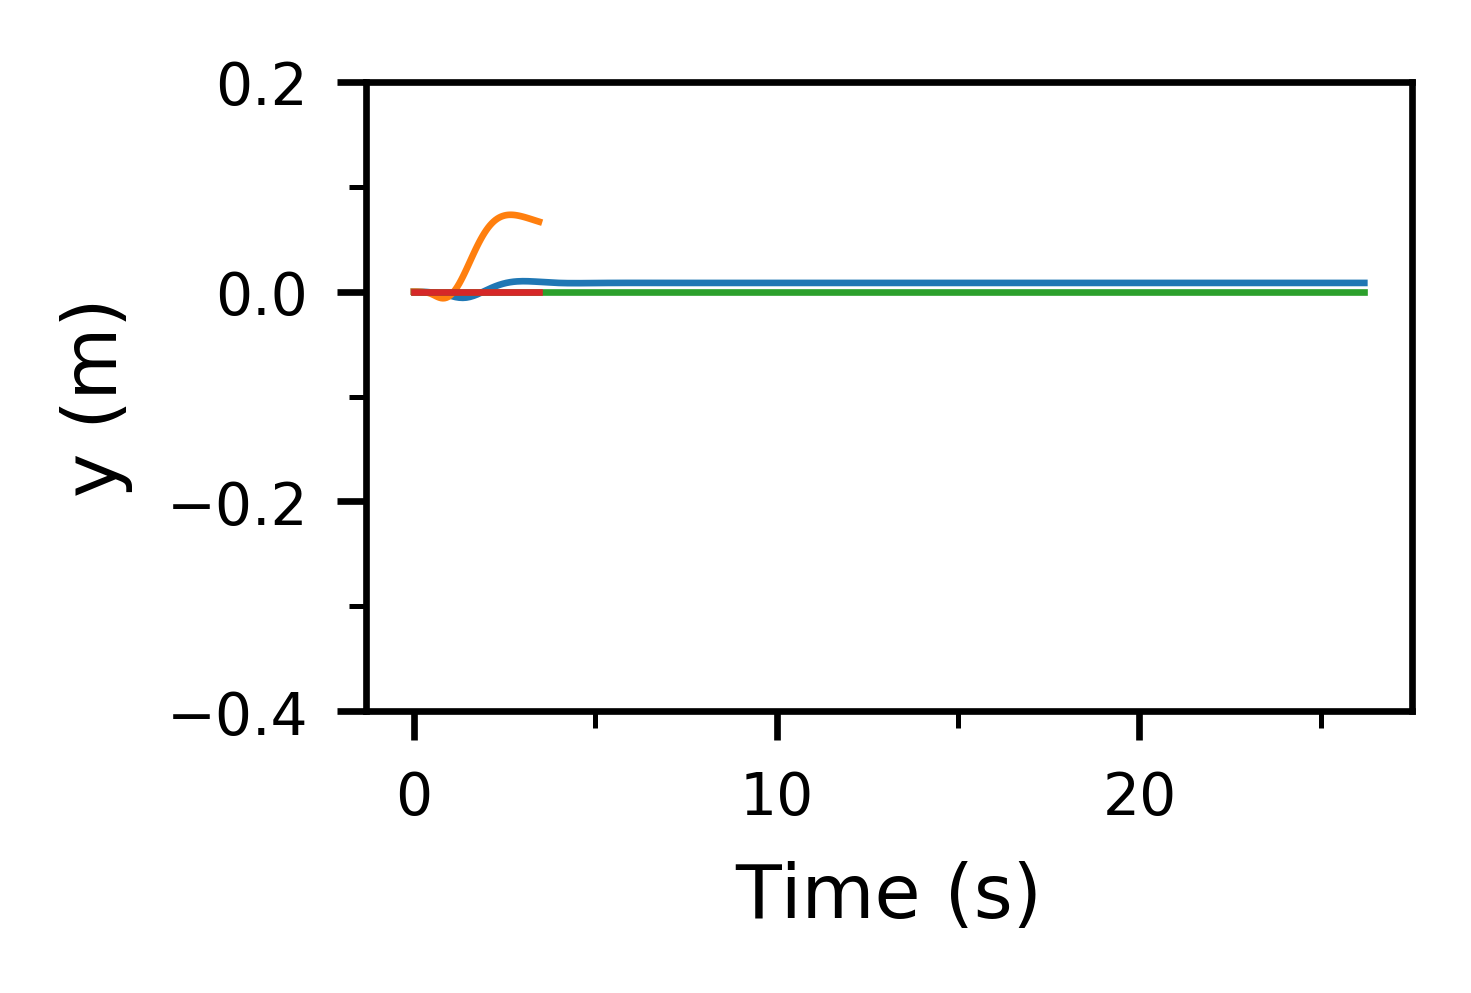

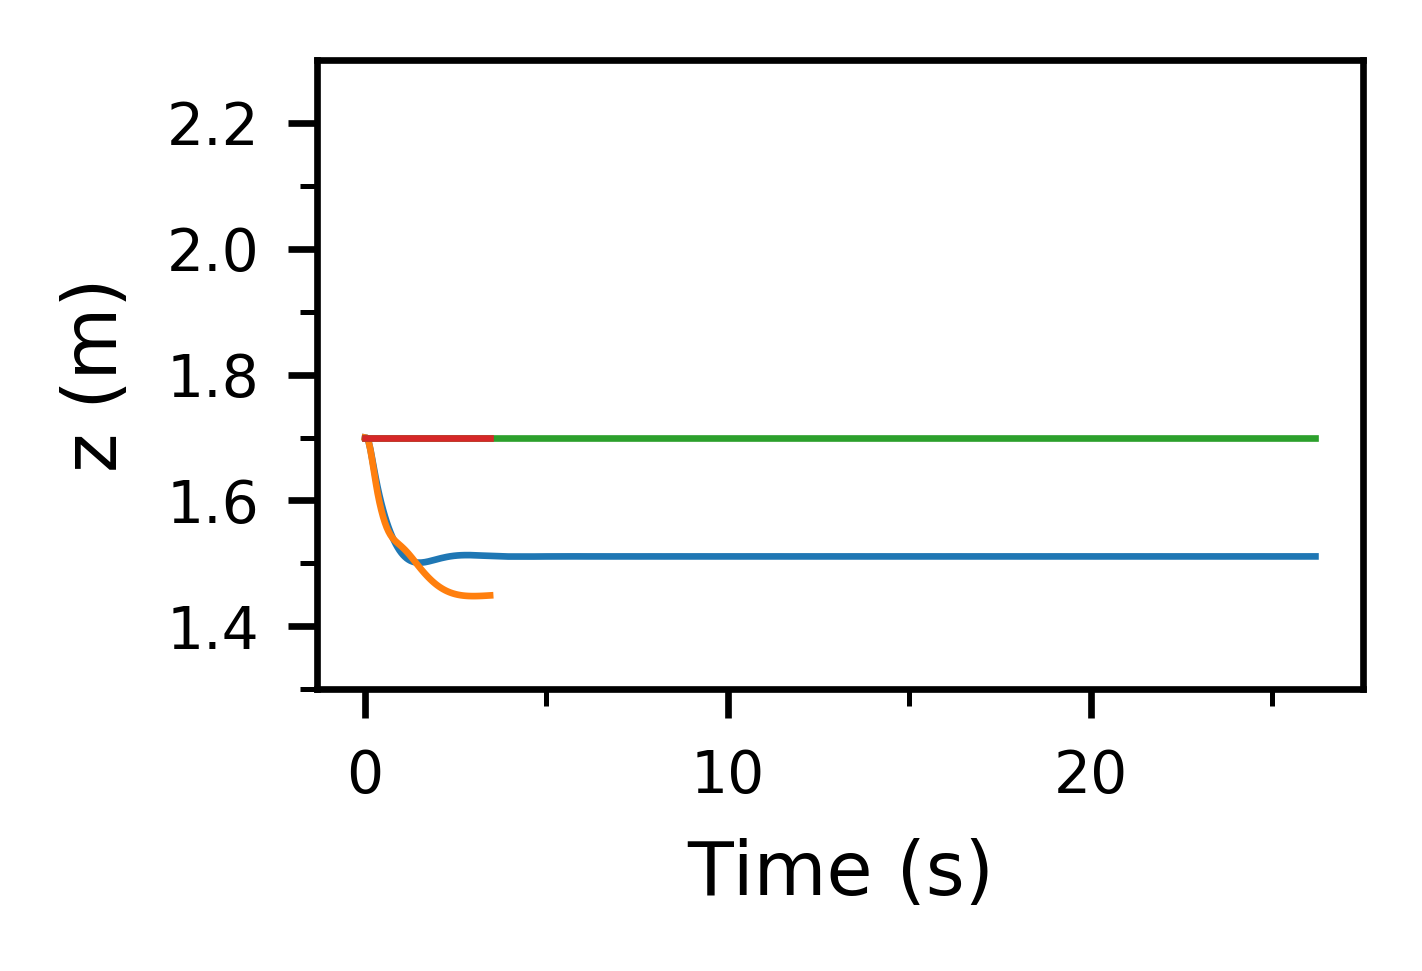

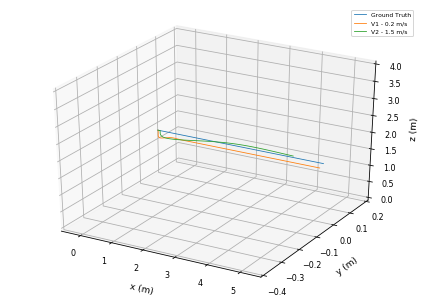

In [13]:
prepare_graphs_sac(set_tau_line1_sac , set_tau_line2_sac, trajectory = 'Line' , namefig="SAC")

# Square

## V1

In [14]:
args.headless=False
args.headless=True

args.task = 'Square'
args.H = task_dict[args.task]['time_horizon']
args.max_timesteps=args.H
# env_reset_mode=False

try: ## hack for jupyter
    env.shutdown()
except:
    pass
set_tau_square1_sac = run_policy(args)


/home/gabriel/anaconda3/envs/pyrep_raw/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Loading
Finished Loading
Finished Loading the weights
Running the policy with time_horizon = ... 565

rewards: mean = 3.709034346830375
rewards: sum = 2095.604405959162
Closing env


## V2

In [15]:
args.headless=False
args.headless=True

args.task = 'Square2'
args.H = task_dict[args.task]['time_horizon']
args.max_timesteps=args.H
# env_reset_mode=False

try: ## hack for jupyter
    env.shutdown()
except:
    pass
set_tau_square2_sac = run_policy(args)


Loading
Finished Loading
Finished Loading the weights
Running the policy with time_horizon = ... 225

rewards: mean = 2.7255519424776278
rewards: sum = 613.2491870574662
Closing env


## Plot

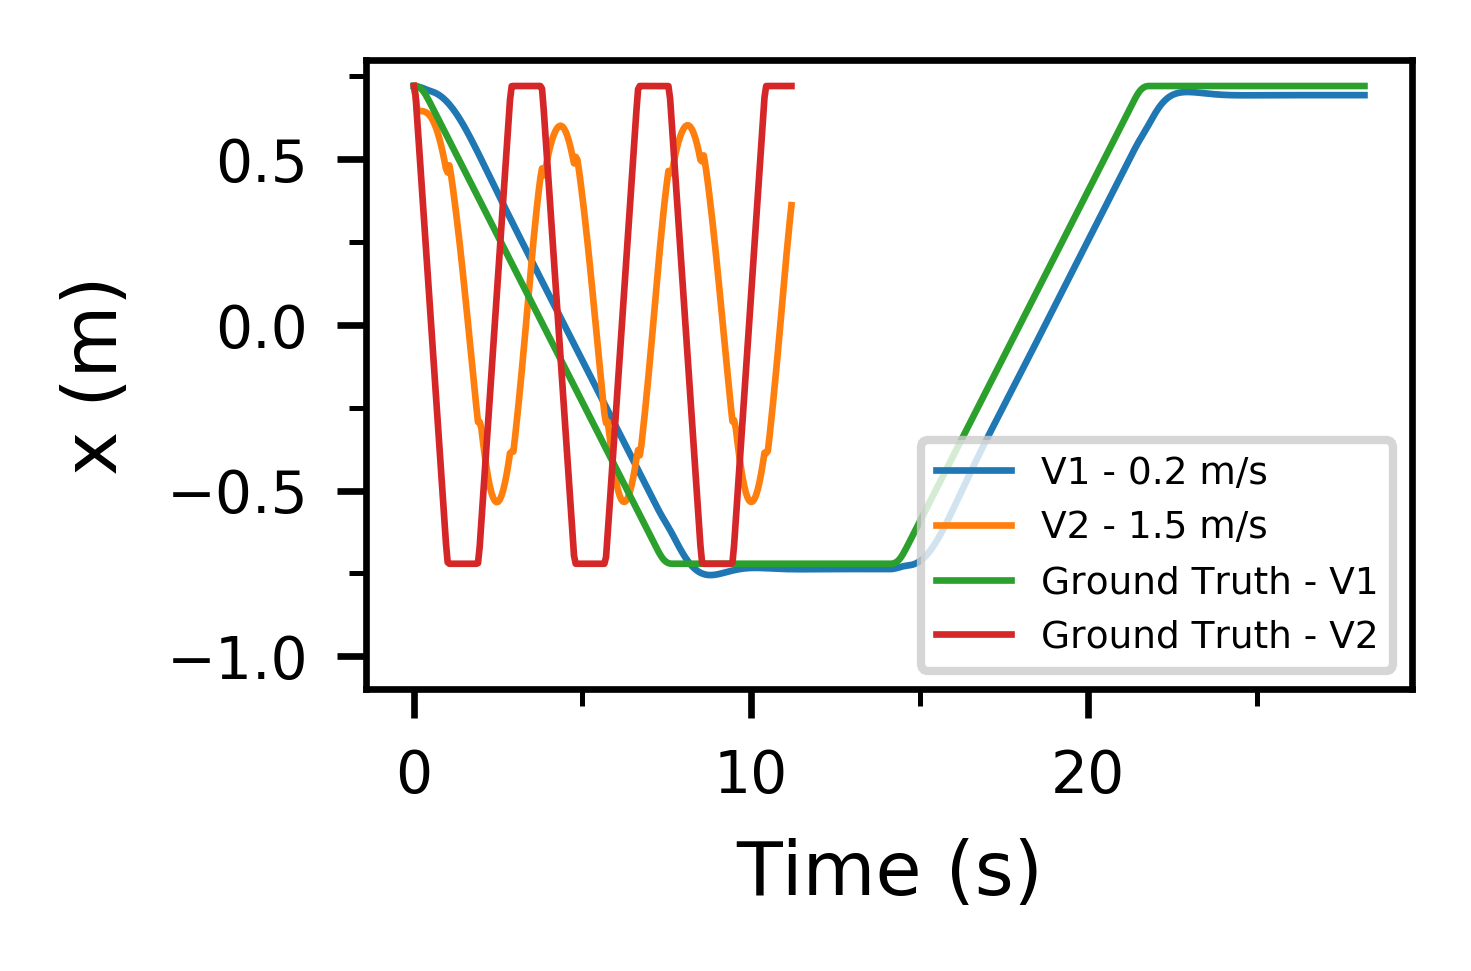

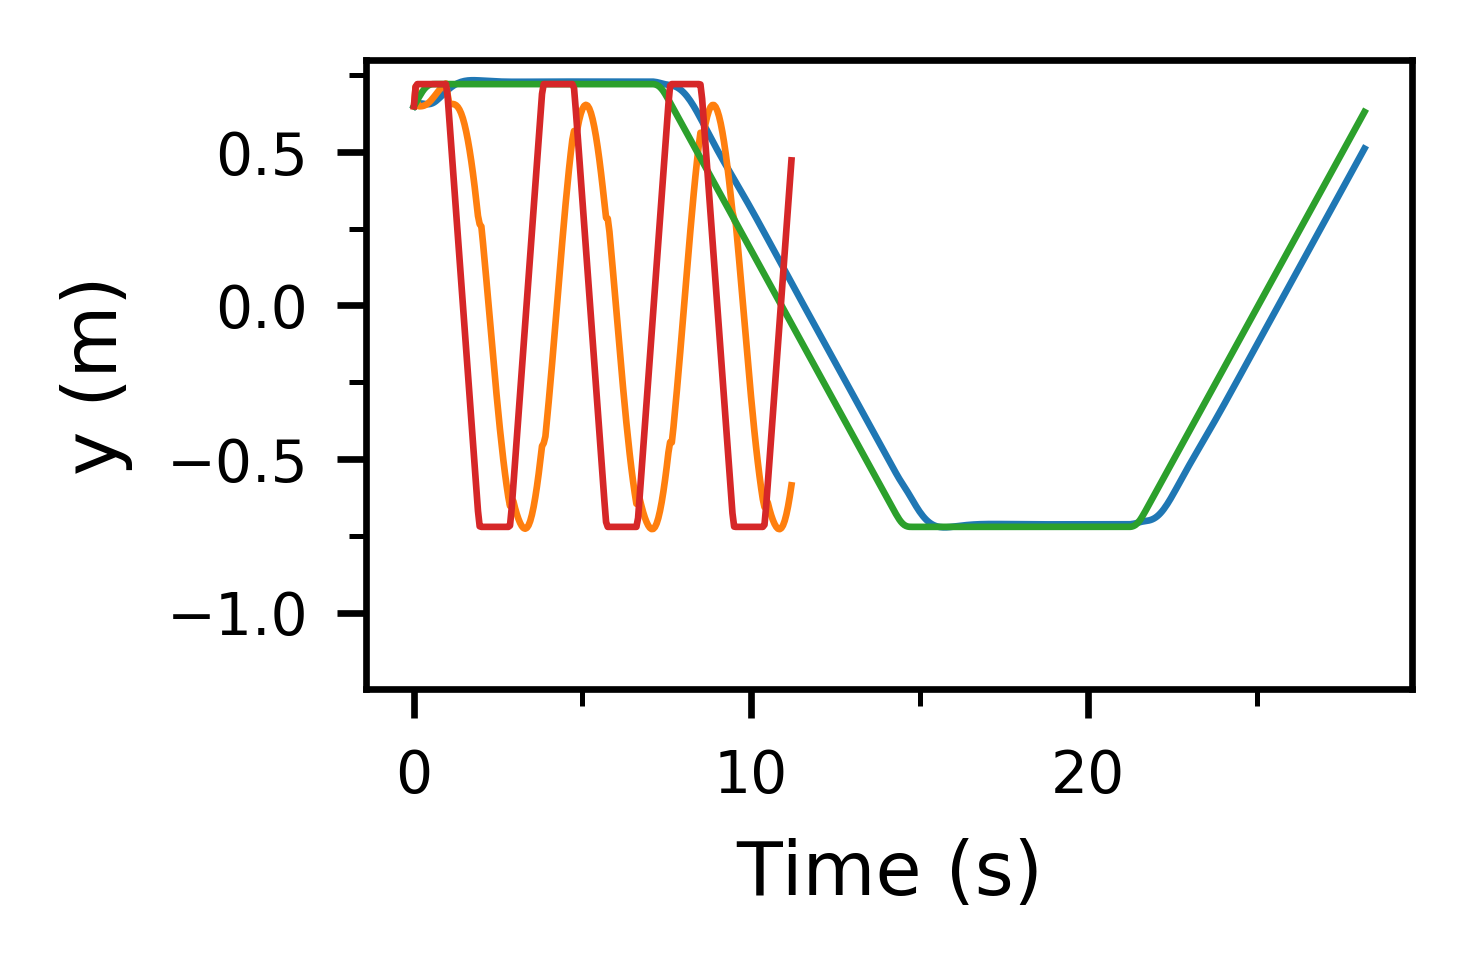

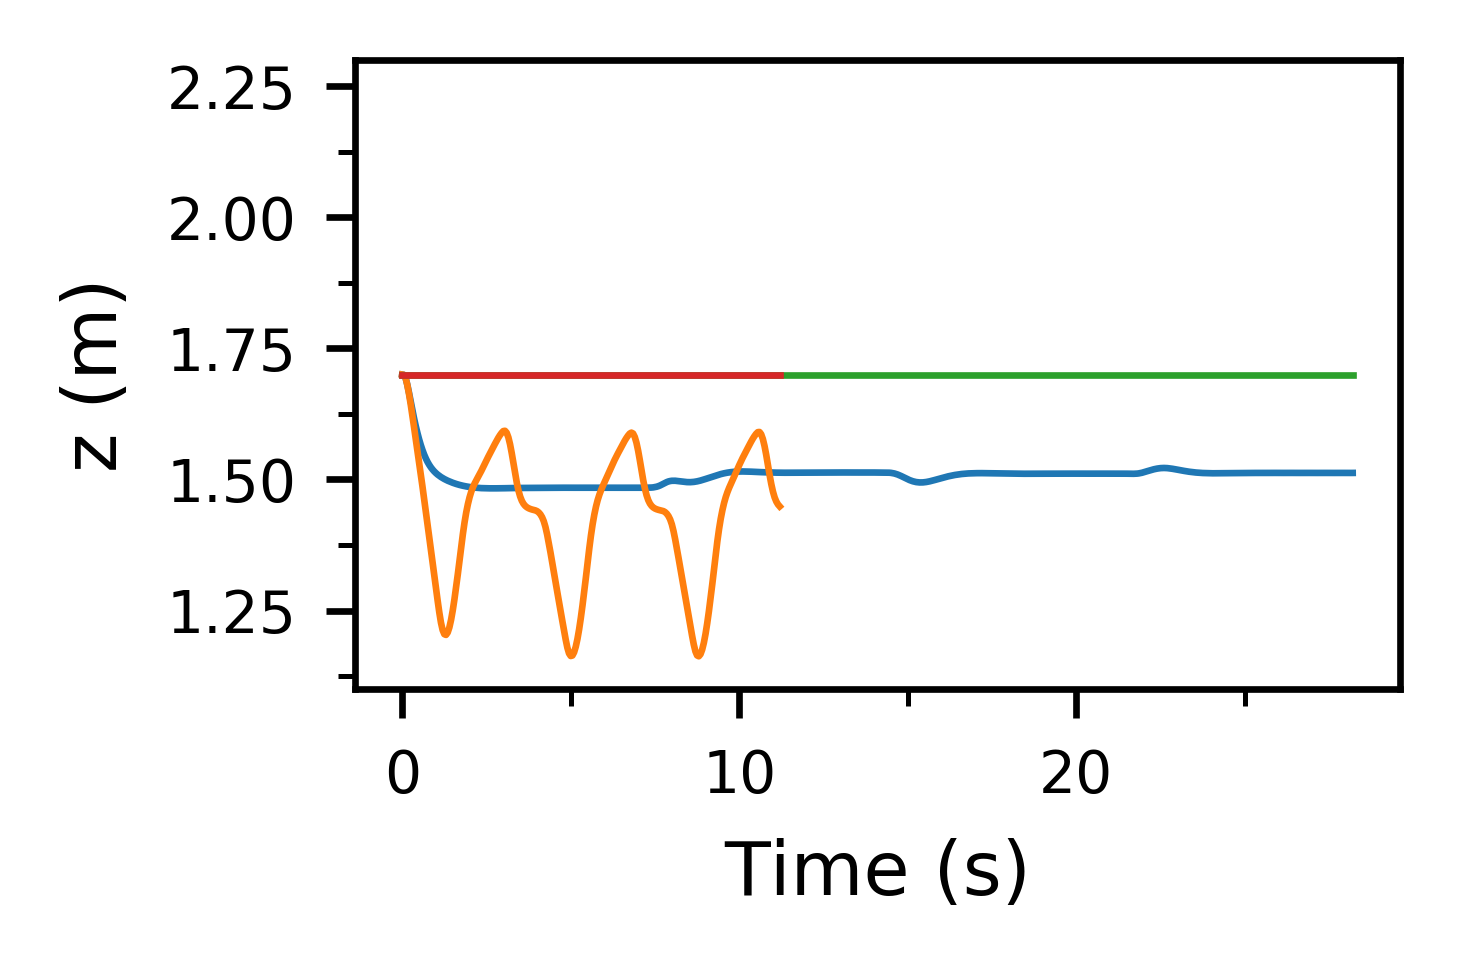

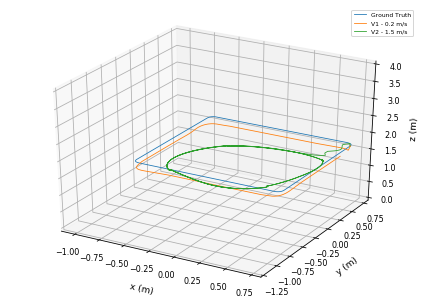

In [16]:
prepare_graphs_sac(set_tau_square1_sac , set_tau_square2_sac, 'Square' , namefig="SAC")


# Sinusoidal

## V1

In [17]:
args.headless=False
args.headless=True

args.task = 'Sinusoidal'
args.H = task_dict[args.task]['time_horizon']
args.max_timesteps=args.H
# env_reset_mode=False

try: ## hack for jupyter
    env.shutdown()
except:
    pass
set_tau_sinusoidal_sac = run_policy(args)


/home/gabriel/anaconda3/envs/pyrep_raw/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Loading
Finished Loading
Finished Loading the weights
Running the policy with time_horizon = ... 900

rewards: mean = 3.752200932181176
rewards: sum = 3376.9808389630584
Closing env


## V2

In [18]:
args.headless=False
args.headless=True

args.task = 'Sinusoidal2'
args.H = task_dict[args.task]['time_horizon']
args.max_timesteps=args.H
# env_reset_mode=False

try: ## hack for jupyter
    env.shutdown()
except:
    pass
set_tau_sinusoida2_sac = run_policy(args)


Loading
Finished Loading
Finished Loading the weights
Running the policy with time_horizon = ... 120

rewards: mean = 3.314034198166816
rewards: sum = 397.68410378001795
Closing env


## Plot

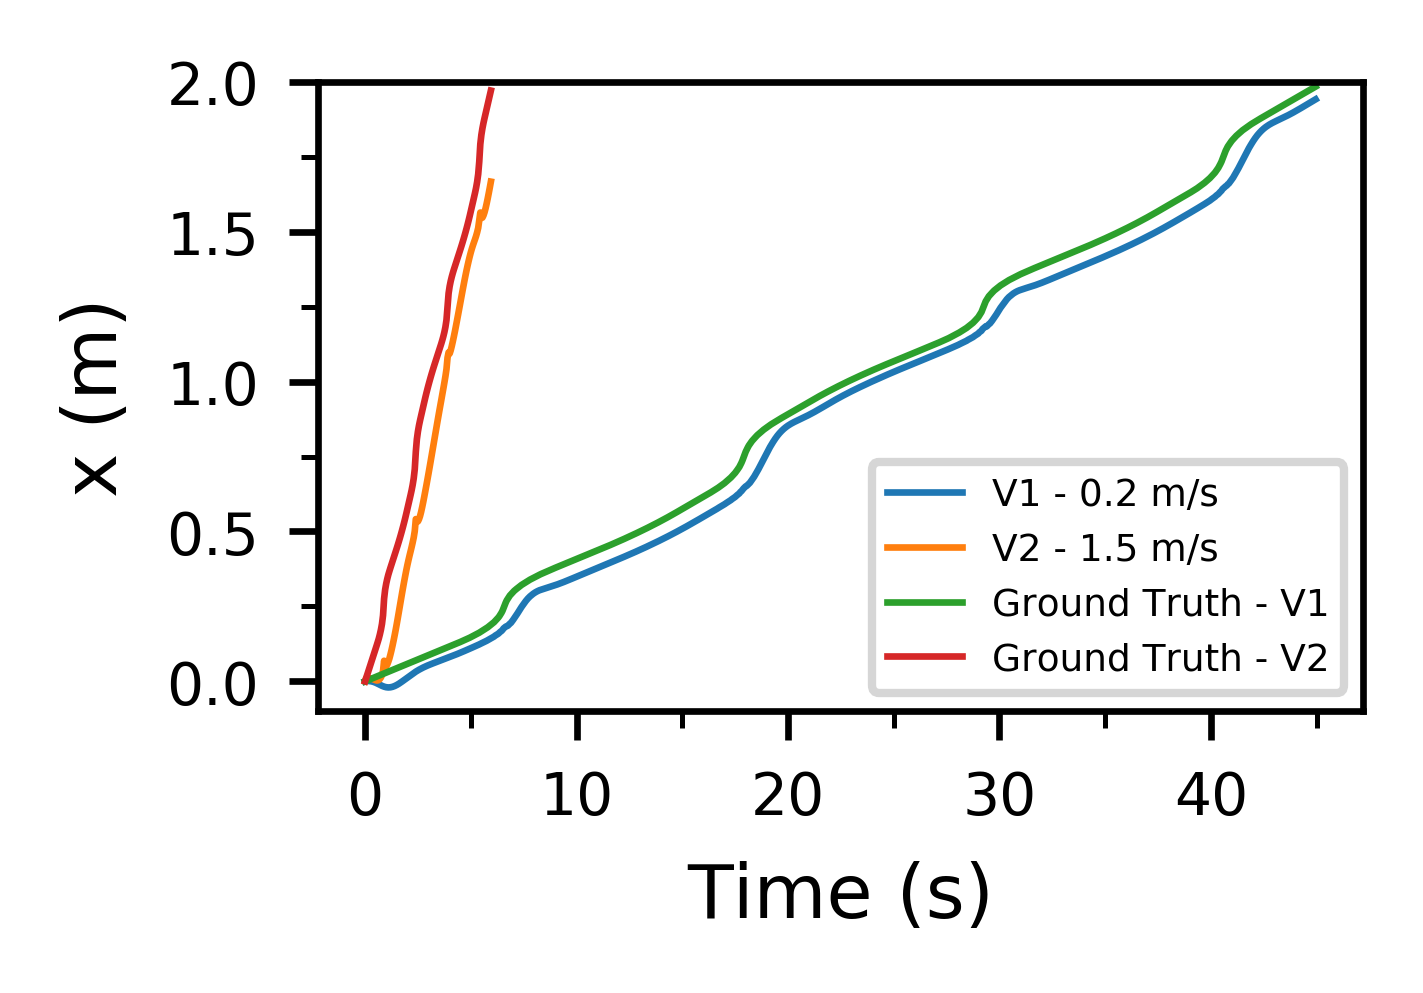

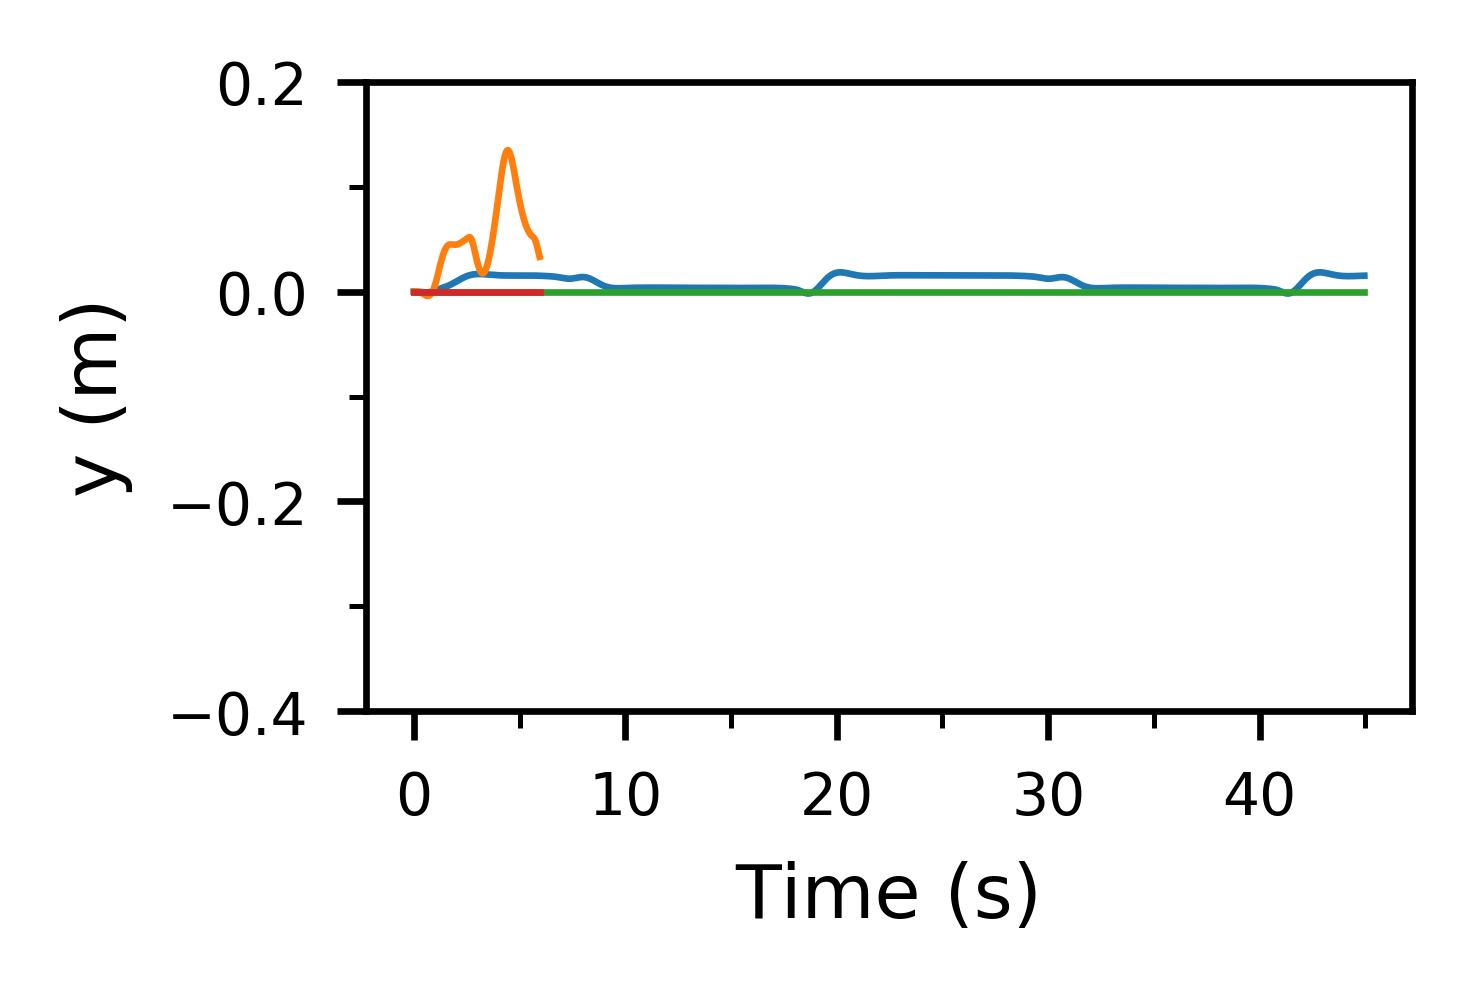

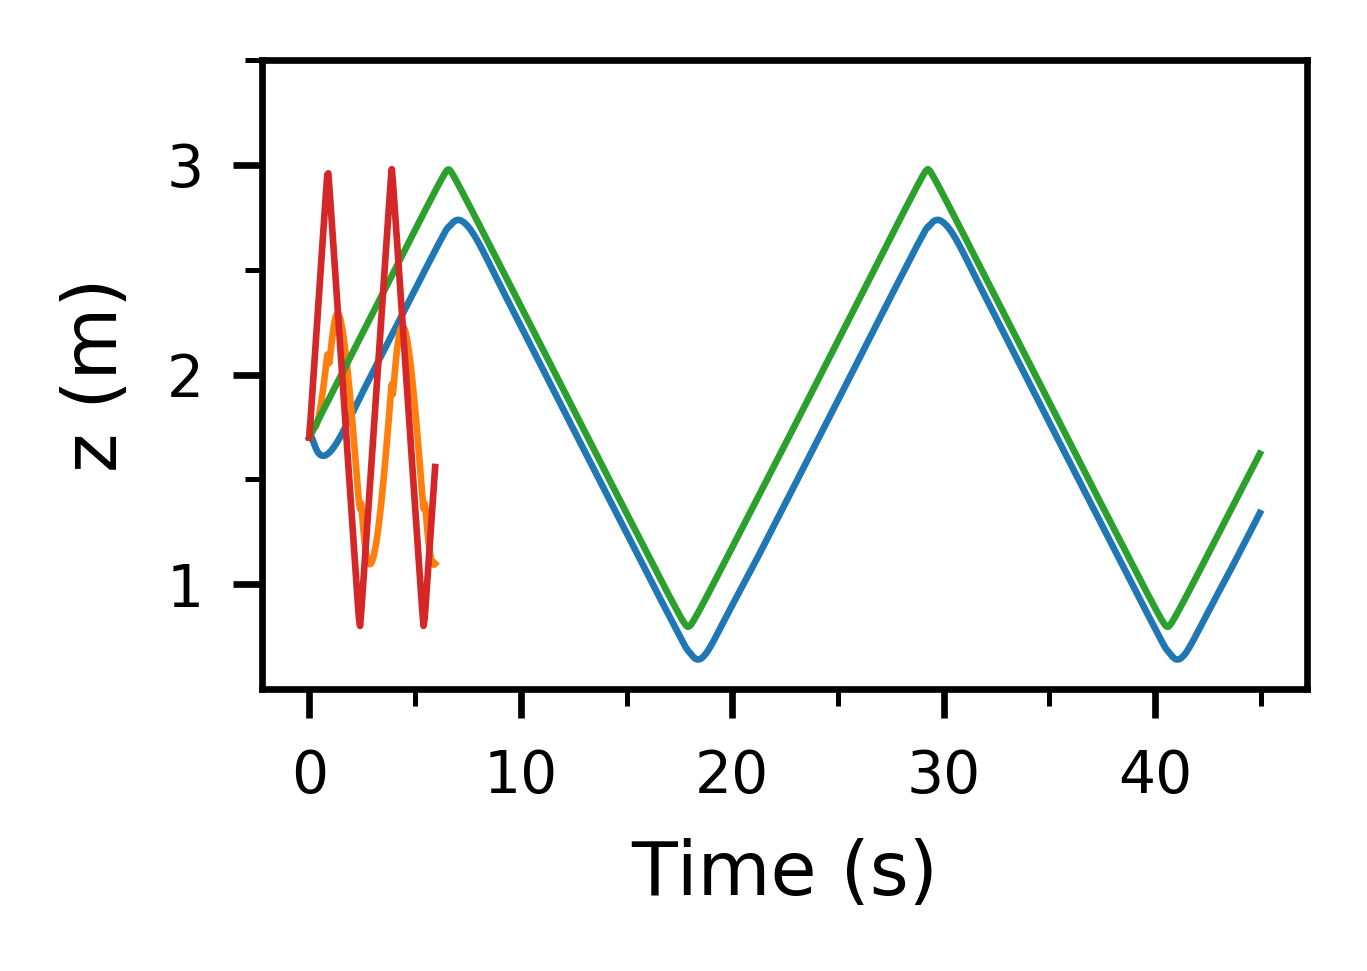

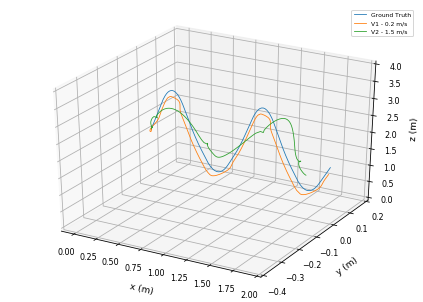

In [19]:
prepare_graphs_sac(set_tau_sinusoidal_sac , set_tau_sinusoida2_sac, trajectory = 'Senoid' , namefig="SAC")
